Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Paul de Graaf"
COLLABORATORS = "Luc de Vries"

---

# Python assignment

The python assignment you can do either on your own or with one other student (i.e. max group size is 2 students).

The first cell of your notebook, should contain a table with the names and SNRs and ANRs of the group members, like so

|Name|SNR|ANR|
|----|---|----|
|Paul de Graaf|2026405|u663408|
|Luc de Vries|2024422|u940400|



See [the webpage](https://janboone.github.io/applied-economics/#org065a005) for details of what we expect to see in this assignment.



# Research question (0.5 points)

What is the life satisfaction of countries in the Eurostat Database in 2017?

# Motivation (0.5 points)

Motivate why this question is interesting.

Life satisfaction is only measured every five years. Therefore, the measurement doesn't measure in the years between and can miss important changes in the life satisfaction. 

# Method (0.5 points)


We will use a neural network to predict the life satisfaction of the countries, based on variables that are measured yearly. That way we can predict life satisfaction every year. 

# Preview of the answers (0.5 points)

Summarize the results that you find and the answer to your research question.

# Main assumptions (0.5 points)

What are the main assumptions that you need to answer the question? If you do a theory notebook, what are the main assumptions of your model? If you use data, what assumptions are needed by your estimation method.

# Python code (6.5 points)


Give the python code in code cells and use markdown cells to explain why you code things in this way and what the outcomes are of the code cells.

Note that the explanation of your code is at least as important as the python code itself.

Create as many python and markdown cells as you need to explain things well.


In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.patches as pl
import seaborn as sns
from scipy import stats, optimize
import random

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sn
from scipy import optimize
import pymc3 as pm
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import arviz as az

import theano
import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
plt.style.use('seaborn')
%matplotlib inline


import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import statsmodels.api as sm

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

In [4]:
lifesat = eurostat.get_data_df('ilc_pw01') # average rating of satisfaction
realgdppc = eurostat.get_data_df('sdg_08_10') # Real gdp per capita
emissionpc = eurostat.get_data_df('t2020_rd300') # greenhouse gas emissions per capita 
socialprotpc = eurostat.get_data_df('tps00100') # social protection expenditure per inhabitant

In [5]:
lifesat.rename({'geo\\time':'geo'},inplace=True,axis=1) # rename geo\time to geo, makes handling the data easier
lifesat = lifesat.groupby(by="geo").mean() # group per country as this is the data that we will use

In [6]:
lifesat = lifesat.reset_index() # reset the index to make sure that the melt function can read the geo columnname correctly
lifesat = lifesat.melt(id_vars= ["geo"],value_vars=np.arange(2013,2019,5),
                        var_name='year',value_name='life satisfaction')# set the values for each years in rows, this allows to combine multiple tables later
                    
lifesat

,geo,year,life satisfaction
0,AL,2013,NaN
1,AT,2013,7.970049
2,BE,2013,7.512500
3,BG,2013,5.433099
4,CH,2013,7.986221
...,...,...,...
83,SI,2018,7.494833
84,SK,2018,7.043855
85,TR,2018,6.043941
86,UK,2018,7.511765


In [7]:
realgdppc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
realgdppc = realgdppc[(realgdppc.unit == 'CLV10_EUR_HAB')] # select only a part of the dataset as growth was also in the dataset
realgdppc = realgdppc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
realgdppc= realgdppc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2022),
                        var_name='year',value_name='Real GDP per capita')# set the values for each years in rows, this allows to combine multiple tables later
realgdppc

,geo,year,Real GDP per capita
0,AL,2012,3230.0
1,AT,2012,36390.0
2,BE,2012,33490.0
3,BG,2012,5390.0
4,CH,2012,58820.0
...,...,...,...
385,SE,2021,44840.0
386,SI,2021,21260.0
387,SK,2021,15660.0
388,TR,2021,NaN


In [8]:
emissionpc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
emissionpc = emissionpc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
emissionpc = emissionpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Emissions')# set the values for each years in rows, this allows to combine multiple tables later

emissionpc

,geo,year,Emissions
0,AT,2012,9.7
1,BE,2012,11.2
2,BG,2012,8.2
3,CH,2012,7.1
4,CY,2012,11.0
...,...,...,...
275,SE,2019,5.2
276,SI,2019,8.2
277,SK,2019,7.3
278,TR,2019,6.3


In [9]:
socialprotpc.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
socialprotpc = socialprotpc.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
socialprotpc = socialprotpc.melt(id_vars= ["geo"],value_vars=np.arange(2012,2020),
                        var_name='year',value_name='Social security')# set the values for each years in rows, this allows to combine multiple tables later

socialprotpc

,geo,year,Social security
0,AT,2012,10125.68
1,BA,2012,NaN
2,BE,2012,9257.45
3,BG,2012,2117.19
4,CH,2012,10770.67
...,...,...,...
323,SE,2019,10276.33
324,SI,2019,6095.87
325,SK,2019,4252.34
326,TR,2019,2692.80


In [10]:
healthcare = eurostat.get_data_df('tespm110') # unmet needs for medical care
educ = eurostat.get_data_df('sdg_04_10') # early leavers from education
jobsecurity = eurostat.get_data_df('ilc_lvhl30') # labour transitions by employment status
crime = eurostat.get_data_df('ilc_mddw03') # crime/violence/vandalism in the area
paygap = eurostat.get_data_df('tesem180') # gender pay gab in unadjusted form

In [11]:
healthcare.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
healthcare = healthcare.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
healthcare  = healthcare [(healthcare.sex == 'T')] # only use the total and not individual sexes
healthcare= healthcare.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='Healthcare')# set the values for each years in rows, this allows to combine multiple tables later
healthcare

,geo,year,Healthcare
0,AL,2012,NaN
1,AT,2012,0.3
2,BE,2012,1.7
3,BG,2012,8.3
4,CH,2012,1.0
...,...,...,...
364,SE,2020,1.5
365,SI,2020,2.7
366,SK,2020,3.2
367,TR,2020,1.9


In [12]:
educ.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
educ = educ.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
educ = educ [(educ.sex == 'T')] # only use the total and not individual sexes
educ= educ.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='educ')# set the values for each years in rows, this allows to combine multiple tables later
educ

,geo,year,educ
0,AT,2012,7.8
1,BE,2012,12.0
2,BG,2012,12.5
3,CH,2012,5.5
4,CY,2012,11.4
...,...,...,...
337,SE,2020,7.7
338,SI,2020,4.1
339,SK,2020,7.6
340,TR,2020,26.7


In [13]:
jobsecurity.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
jobsecurity = jobsecurity.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
jobsecurity = jobsecurity [(jobsecurity.sex == 'T')&(jobsecurity.trans1y == 'TO_UNE')&(jobsecurity.wstatus.isin([ 'EMP_PT',"EMP","EMP_FT"]))]# only use the total and not individual sexes and people that get employed a year later when they are employed
jobsecurity= jobsecurity.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
jobsecurity= jobsecurity.melt(id_vars= ["geo","trans1y", "wstatus"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='jobsecurity')# set the values for each years in rows, this allows to combine multiple tables later
jobsecurity = jobsecurity.groupby(by=["geo","year"]).mean() # calculate the mean per year and country
jobsecurity= jobsecurity.reset_index()# reset the index to make sure that the rows are filled
jobsecurity


,geo,year,jobsecurity
0,AL,2012,NaN
1,AL,2013,NaN
2,AL,2014,NaN
3,AL,2015,NaN
4,AL,2016,NaN
...,...,...,...
382,UK,2016,1.600000
383,UK,2017,1.233333
384,UK,2018,1.300000
385,UK,2019,NaN


In [14]:
crime.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
crime = crime.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
crime = crime [(crime.incgrp == 'TOTAL')& (crime.hhtyp == "TOTAL")] # only use the total and not individual sexes
crime= crime.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='crime')# set the values for each years in rows, this allows to combine multiple tables later
crime

,geo,year,crime
0,AL,2012,NaN
1,AT,2012,11.7
2,BE,2012,14.5
3,BG,2012,26.9
4,CH,2012,16.5
...,...,...,...
391,SI,2020,7.3
392,SK,2020,4.3
393,TR,2020,9.8
394,UK,2020,NaN


In [15]:
paygap.rename({'geo\\time':'geo'},inplace=True,axis=1)# rename geo\time to geo, makes handling the data easier
paygap = paygap.reset_index()# reset the index to make sure that the melt function can read the geo columnname correctly
paygap= paygap.melt(id_vars= ["geo"],value_vars=np.arange(2012,2021),
                        var_name='year',value_name='paygap in %')# set the values for each years in rows, this allows to combine multiple tables later
paygap

,geo,year,paygap in %
0,AL,2012,NaN
1,AT,2012,22.9
2,BE,2012,8.3
3,BG,2012,15.1
4,CH,2012,17.4
...,...,...,...
346,SE,2020,11.2
347,SI,2020,3.1
348,SK,2020,15.8
349,TR,2020,NaN


In [16]:
df1=lifesat.merge(crime,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df2=df1.merge(realgdppc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df3=df2.merge(emissionpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df4=df3.merge(socialprotpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df5=df4.merge(healthcare,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df6=df5.merge(educ,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df7=df6.merge(jobsecurity,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df=df7.merge(paygap,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df



,geo,year,life satisfaction,crime,Real GDP per capita,Emissions,Social security,Healthcare,educ,jobsecurity,paygap in %
0,AL,2013,NaN,NaN,3260.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,2013,7.970049,11.3,36180.0,9.6,10375.67,0.4,7.5,3.500000,22.3
2,BE,2013,7.512500,19.4,33490.0,11.1,9528.13,1.9,11.0,3.300000,7.5
3,BG,2013,5.433099,25.8,5390.0,7.7,2301.75,8.9,12.5,3.966667,14.1
4,CH,2013,7.986221,14.5,59200.0,7.1,11328.49,1.2,5.6,1.500000,17.6
...,...,...,...,...,...,...,...,...,...,...,...
83,SI,2018,7.494833,7.9,20240.0,8.5,5810.55,3.3,4.2,3.100000,9.3
84,SK,2018,7.043855,4.8,15510.0,7.8,4132.41,2.6,8.6,NaN,19.8
85,TR,2018,6.043941,11.1,11560.0,6.6,2545.61,2.9,31.0,3.933333,NaN
86,UK,2018,7.511765,24.2,32640.0,7.5,7914.69,4.5,10.7,1.300000,19.8


In [17]:

df9 = df[df.year == 2013] # select only year 2013 and 2018, because life satisfaction is measured in these years
df10 = df[df.year == 2018]# select only year 2013 and 2018, because life satisfaction is measured in these years

df = pd.concat([df9,df10]) #merge 2013 and 2018
df['country'] = df['geo'].replace(eurostat_dictionary)  #replace geo by country following the eurostat dictionary to display it nice in the graph later on

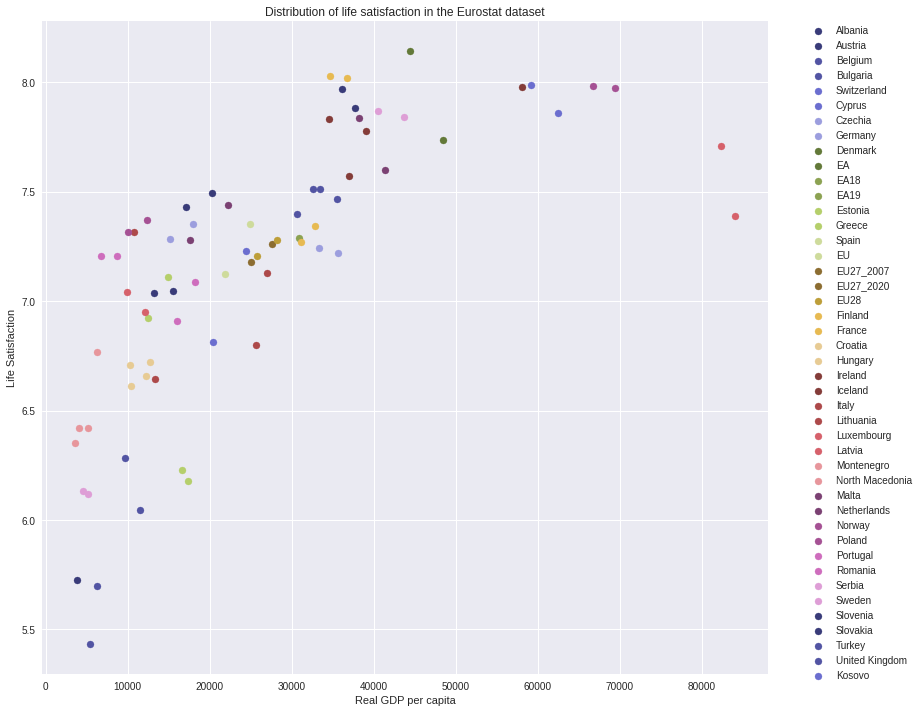

In [18]:
plt.style.use('seaborn-dark-palette')  # choise of style
NUM_COLORS = 39 # number of colors/countries used 

cm = plt.get_cmap('tab20b') # get the colormap 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)  # rescale the colors based on the numbers to get the optimal difference in colors
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm) # handles the colormap and the colors

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])) # makes sure that countries do not get the same color based on the number of colors

fig, (ax1) = plt.subplots(1, sharey=True, sharex=True,figsize=(13,12)) # create plotsize


for country in df.country.unique():  # for every country 
    mask = (df.country == country)   # test and make mask if the row is a country value
    ax1.scatter(df[mask]['Real GDP per capita'], df[mask]['life satisfaction'], label = country) # set the x and y and group per country
   
ax1.set_xlabel('Real GDP per capita') # name x-axis
ax1.set_ylabel('Life Satisfaction')# name y-axis
ax1.set_title('Distribution of life satisfaction in the Eurostat dataset') # set title 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.); # instruction for legend 

In [19]:
meanlifsat = df['life satisfaction'].mean() # calculate mean of lifa satisfaction
stdlifsat = df['life satisfaction'].std()# calculate standard deviation of lifa satisfaction

df_x = df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] # create dataframe with all variables
df[['life satisfaction','crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] = (df_x-df_x.mean())/df_x.std() # standerdize variables
df = df.rename(columns={'Real GDP per capita': 'Gdp', 'Social security': 'Socsec', 'paygap in %': 'paygap', 'life satisfaction': 'Lifesat'}) # rename column names
df = df[['Lifesat','crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]]  # select correct columns

def fillNaN_with_unifrand(df):   # formula to fill NaN with random normal distributed value
    a = df.values   #create values from the df 
    m = pd.isna(a) # mask of NaNs telling whether the value is an NaN
    mu, sigma = 0, 1  # mu and sigma used in the normal distribution function
    a[m] = np.random.normal(mu, sigma, size=m.sum()) # make of every NaN a different value 
    return df

df= fillNaN_with_unifrand(df) # call the formula from above the actually replace the NaNs
df['Lifesat'] = ((df['Lifesat']*stdlifsat)+ meanlifsat)*10# create values from 0-100 based on original value
df['Lifesat2'] = ((df['Lifesat'])) # create second lifesat which can be used later on 
X = df[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values  #create X values
y = df['Lifesat'].values # create outcome values
y2 =df['Lifesat2'].values # crease outocme values for diffent use later on

In [20]:
train = df[:65] # split test and train set 
test= df[65:89]# split test and train set 

trainy = train['Lifesat'].values   # define train set outcomes
trainX = train[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values # define train set variables

testy = test['Lifesat'].values# define test set outcomes
testX = test[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]].values# define test set variables


In [21]:
model = keras.Sequential([
    keras.layers.Dense(100, input_dim = 8, activation='tanh'), # input layer, we chose tanh function as this gives the function similar to the distribution in the graph of real gdp and life satisfaction
    keras.layers.Dense(100, activation = 'tanh'),              # hidden
    keras.layers.Dense(100, activation = 'tanh'),              # hidden
    keras.layers.Dense(101, activation = 'softmax')             # output 101 is not included so chooses between 1 and 100 So that we predict with one decimal
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy')  # define how the model should compile 
                                                     # it doesn't make sense to use accuracy as we have to predict the same label as the original which is hard to do with numbers with decimals, thus focus on loss


In [22]:
history = model.fit(trainX,trainy,epochs=50,validation_data=(testX, testy)) # actually let the model fit the data and than test whether the trained model also works on the test dataset
# we use 50 epochs, because if we used more the validation loss would increase which would suggest overfitting. at 50 epochs the validation loss also doesn't decrease so there is no underfitting visable.

Epoch 1/50
3/3 [==============================] - 1s 123ms/step - loss: 4.7317 - val_loss: 4.6650
Epoch 2/50
3/3 [==============================] - 0s 44ms/step - loss: 4.5404 - val_loss: 4.5780
Epoch 3/50
3/3 [==============================] - 0s 8ms/step - loss: 4.3971 - val_loss: 4.4999
Epoch 4/50
3/3 [==============================] - 0s 8ms/step - loss: 4.2716 - val_loss: 4.4340
Epoch 5/50
3/3 [==============================] - 0s 48ms/step - loss: 4.1565 - val_loss: 4.3733
Epoch 6/50
3/3 [==============================] - 0s 42ms/step - loss: 4.0376 - val_loss: 4.3172
Epoch 7/50
3/3 [==============================] - 0s 9ms/step - loss: 3.9218 - val_loss: 4.2569
Epoch 8/50
3/3 [==============================] - 0s 10ms/step - loss: 3.8153 - val_loss: 4.1919
Epoch 9/50
3/3 [==============================] - 0s 45ms/step - loss: 3.7021 - val_loss: 4.1384
Epoch 10/50
3/3 [==============================] - 0s 48ms/step - loss: 3.5918 - val_loss: 4.0954
Epoch 11/50
3/3 [==============

<AxesSubplot:>

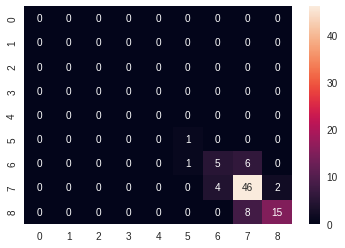

In [23]:
y_pred = (model.predict(X)).argmax(axis=1)    # use the model to make predictions 
y_pred = (y_pred/10).round()  # we round the numbers to basic 1-10 because the matrix is not readible with values 1-100
y3= (y2/10).round()# we round the numbers to basic 1-10  because the matrix is not readible with values 1-100
matrix = tf.math.confusion_matrix(y3, y_pred) # set the prediction in a model with the actual values 
sn.heatmap(matrix,annot=True) # create heatmap 

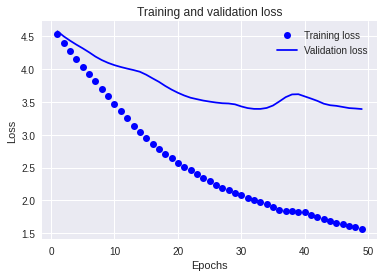

In [24]:
loss = history.history['loss'][1:]   # training loss from all different epochs
val_loss = history.history['val_loss'][1:] # validation loss from all different epochs

epochs = range(1, len(loss)+1)  # count the number of epochs

plt.plot(epochs, loss, 'bo', label='Training loss') # plot the epochs and the losses of training and validation 
plt.plot(epochs, val_loss, 'b', label='Validation loss')# plot the epochs and the losses of training and validation 
plt.title('Training and validation loss')# plot the epochs and the losses of training and validation 
plt.xlabel('Epochs')# plot the epochs and the losses of training and validation 
plt.ylabel('Loss')# plot the epochs and the losses of training and validation 
plt.legend()# plot the epochs and the losses of training and validation 
plt.show()# plot the epochs and the losses of training and validation 


In [25]:
df2=realgdppc.merge(emissionpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df3=df2.merge(crime,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df4=df3.merge(socialprotpc,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df5=df4.merge(healthcare,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df6=df5.merge(educ,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
df7=df6.merge(jobsecurity,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe
dftest=df7.merge(paygap,how='left',left_on=['geo','year'], right_on=['geo','year']) # merge individual dataframes to total dataframe

dftest2=dftest# create second set of data
dftest = dftest[dftest.year == 2017] # year to find life satisfaction from


dftest_x = dftest[['crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] # create dataframe with all variables
dftest[['crime', 'Real GDP per capita', "Emissions","Social security", "Healthcare", "educ", "jobsecurity", "paygap in %"]] = (dftest_x-dftest_x.mean())/dftest_x.std() # standerdize variables
dftest = dftest.rename(columns={'Real GDP per capita': 'Gdp', 'Social security': 'Socsec', 'paygap in %': 'paygap', 'life satisfaction': 'Lifesat'}) # rename column names
dftest = dftest[['crime', 'Gdp', "Emissions","Socsec", "Healthcare", "educ", "jobsecurity", "paygap"]]  # select correct columns


def fillNaN_with_unifrand(dftest):   # formula to fill NaN with random normal distributed value
    a = dftest.values   #create values from the df 
    m = pd.isna(a) # mask of NaNs telling whether the value is a NaN
    mu, sigma = 0, 1  # mu and sigma used in the normal distribution function
    a[m] = np.random.normal(mu, sigma, size=m.sum()) # make of every NaN a different value 
    return dftest

dftest= fillNaN_with_unifrand(dftest) # call the formula from above the actually replace the NaNs
X2017 = dftest.values # create varaibles to use in prediction

In [26]:
y2017 = (model.predict(X2017)).argmax(axis=1)  # actually using the model to predict data.
y2017

array([70, 72, 72, 54, 78, 73, 72, 72, 78, 72, 71, 61, 68, 72, 72, 80, 72,
       66, 72, 78, 78, 72, 72, 77, 70, 66, 66, 72, 72, 78, 73, 73, 72, 62,
       72, 73, 72, 72, 72])

In [27]:
dftest2 = dftest2[dftest2.year == 2017] # year to find life satisfaction 
dftest2['country'] = dftest2['geo'].replace(eurostat_dictionary)# add country variable was not done in this dataset 
dftestgdp = dftest2[["Real GDP per capita","country"]] # select only these two columns
dftestgdp["lifesat"] = y2017.tolist() # add the prediction lifesatisfaction to the dataframe
dfgraph = dftestgdp # rename

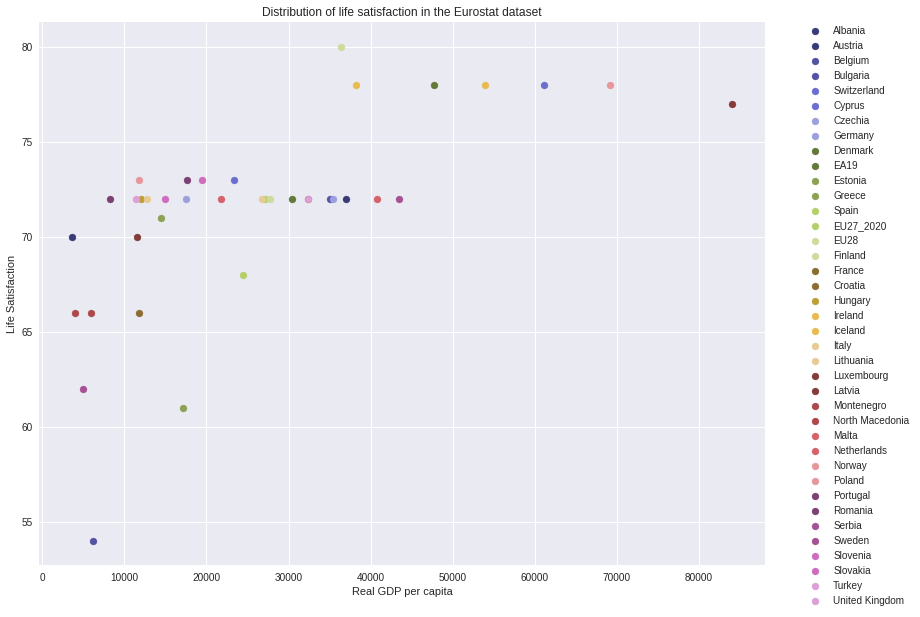

In [28]:
plt.style.use('seaborn-dark-palette')# choise of style
NUM_COLORS = 39# number of colors/countries used 

cm = plt.get_cmap('tab20b') # get the colormap 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)# rescale the colors based on the numbers to get the optimal difference in colors
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm) # handles the colormap and the colors

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))# makes sure that countries do not get the same color based on the number of colors

fig, (ax1) = plt.subplots(1, sharey=True, sharex=True,figsize=(13,10)) # create plotsize


for country in dfgraph.country.unique():# for every country 
    mask = (dfgraph.country == country) # test and make mask if the row is a country value
    ax1.scatter(dfgraph[mask]['Real GDP per capita'], dfgraph[mask]['lifesat'], label = country)# set the x and y and group per country
   


ax1.set_xlabel('Real GDP per capita')# name x-axis
ax1.set_ylabel('Life Satisfaction')# name y-axis
ax1.set_title('Distribution of life satisfaction in the Eurostat dataset') # set title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.); # settings for legend

## show with self made numbers that method works. 

In [29]:
var1 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var2 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var3 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var4 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var5 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var6 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var7 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 
var8 = np.array(pm.Normal.dist(0,1).random(size=100))#create 100 normal distributed value to create a variable 

In [30]:
outcome = var1*6+var2*2+var3*9+var4*20+var5*1+var6*3+var7*18+var8*5 # create outcome variable 
outcome = (((outcome-outcome.mean())/outcome.std()*stdlifsat) + meanlifsat)*10# standerdize outcome variable and use mean and standard deviation from life statisfaction

In [31]:
data = np.concatenate((np.matrix(outcome).T,np.matrix(var1).T,np.matrix(var2).T,np.matrix(var3).T,np.matrix(var4).T,np.matrix(var5).T,np.matrix(var6).T,np.matrix(var7).T,np.matrix(var8).T),axis=1) # merge arrays columnwise by using axis=1

In [32]:
X2 = data[:,[1,2,3,4,5,6,7,8]] # create variable dataset
y2 = data[:,[0]]# create outcome dataset
train2 = data[:75] # create training dataset
test2= data[75:101]# create testing dataset

trainy2 = train2[:,[0]]# create training outcome dataset
testy2 = test2[:,[0]]# create testing outcome dataset

trainX2 = train2[:,[1,2,3,4,5,6,7,8]]# create training variables dataset
testX2 = test2[:,[1,2,3,4,5,6,7,8]]# create testing variables dataset

In [33]:
history = model.fit(trainX2,trainy2,epochs=50,validation_data=(testX2, testy2)) # fit the model with new test and training sets 

Epoch 1/50
3/3 [==============================] - 1s 116ms/step - loss: 5.4303 - val_loss: 5.4982
Epoch 2/50
3/3 [==============================] - 0s 41ms/step - loss: 5.3513 - val_loss: 5.4038
Epoch 3/50
3/3 [==============================] - 0s 11ms/step - loss: 5.1953 - val_loss: 5.2609
Epoch 4/50
3/3 [==============================] - 0s 50ms/step - loss: 5.0001 - val_loss: 5.0943
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 4.7750 - val_loss: 4.9206
Epoch 6/50
3/3 [==============================] - 0s 12ms/step - loss: 4.5434 - val_loss: 4.7397
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 4.3116 - val_loss: 4.5639
Epoch 8/50
3/3 [==============================] - 0s 47ms/step - loss: 4.0839 - val_loss: 4.3945
Epoch 9/50
3/3 [==============================] - 0s 48ms/step - loss: 3.8628 - val_loss: 4.2404
Epoch 10/50
3/3 [==============================] - 0s 46ms/step - loss: 3.6651 - val_loss: 4.0996
Epoch 11/50
3/3 [===========

<AxesSubplot:>

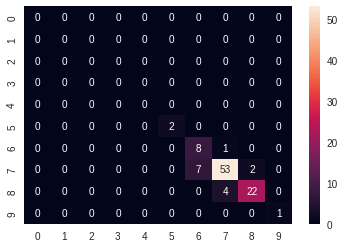

In [34]:
y_pred2 = (model.predict(X2)).argmax(axis=1)# use the model to make predictions 
y_pred2 = (y_pred2/10).round()
y2= (y2/10).round()
matrix = tf.math.confusion_matrix(y2, y_pred2)# set the prediction in a model with the actual values 
sn.heatmap(matrix,annot=True)

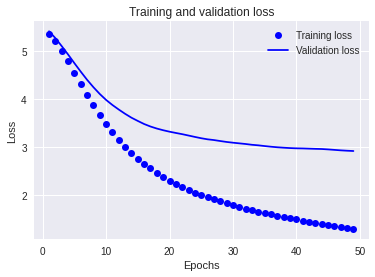

In [35]:
loss = history.history['loss'][1:]# training loss from all different epochs
val_loss = history.history['val_loss'][1:]# validation loss from all different epochs 

epochs = range(1, len(loss)+1) # count the number of epochs

plt.plot(epochs, loss, 'bo', label='Training loss') # plot the epochs and the losses of training and validation 
plt.plot(epochs, val_loss, 'b', label='Validation loss') # plot the epochs and the losses of training and validation 
plt.title('Training and validation loss') # plot the epochs and the losses of training and validation 
plt.xlabel('Epochs') # plot the epochs and the losses of training and validation 
plt.ylabel('Loss') # plot the epochs and the losses of training and validation 
plt.legend() # plot the epochs and the losses of training and validation 
plt.show() # plot the epochs and the losses of training and validation 


# Baysian Model

In [48]:
t = np.arange(0,88,1) # arange the number of t which is goes to 88 


with pm.Model() as exponential_model:
    a = pm.HalfNormal('a',0.1)    #create the variable that stretches the tahn formula
    b = pm.Normal('b',mu = 50, sd = 10) # create starting variable on basis of original graph before 
    c = pm.Normal('c',mu = 10, sd = 3) # create the size of the effectiveness of the tanh formula
    y = np.tanh(t*a)*c+b  # actual tanh formula
    eps = pm.HalfNormal('eps',1)  # create eps 
    lifesat = pm.Normal('lifesat', mu = y,\
                             sigma = eps, observed = df.Lifesat) # create variable lifesat with the observed life satisfaction data from before
    prior_predictive = pm.sample_prior_predictive(samples=50)  # use 50 samples

In [49]:
df.Lifesat

0     76.078542
1     79.700490
2     75.125000
3     54.330986
4     79.862210
        ...    
83    74.948328
84    70.438547
85    60.439414
86    75.117647
87    66.371512
Name: Lifesat, Length: 88, dtype: float64

In [57]:
with exponential_model:
    trace = pm.sample(tune=3000)     # tune the model with 3000 tunes 
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, c, b, a]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 98 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6043302253030842, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6533640766492005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

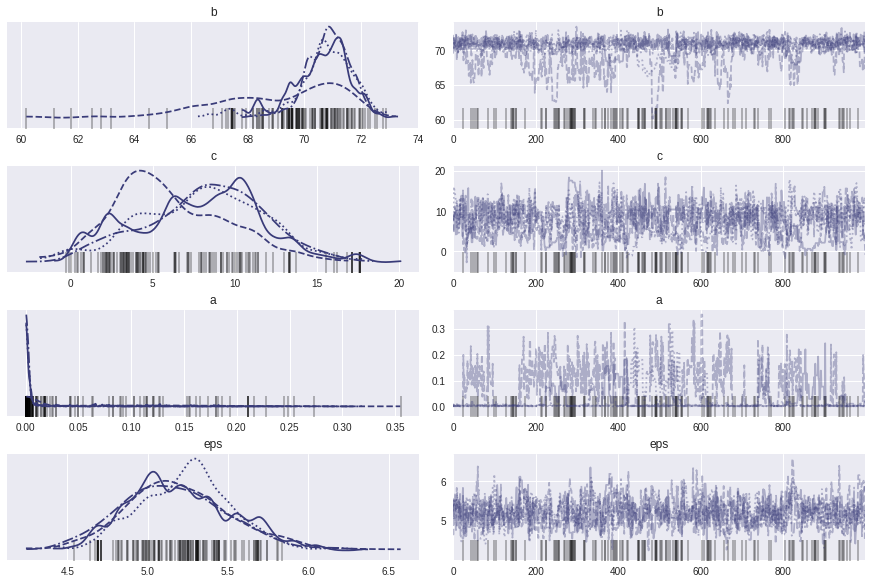

In [58]:
pm.traceplot(trace)  # show the trace plot

In [59]:
az.summary(trace) # give summary of the trace 



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,70.280,1.649,67.071,72.659,0.365,0.262,37.0,39.0,1.09
c,7.490,3.755,0.421,13.877,0.284,0.201,181.0,302.0,1.03
a,0.030,0.059,0.000,0.160,0.013,0.010,30.0,127.0,1.10
eps,5.204,0.324,4.639,5.827,0.015,0.010,490.0,757.0,1.01


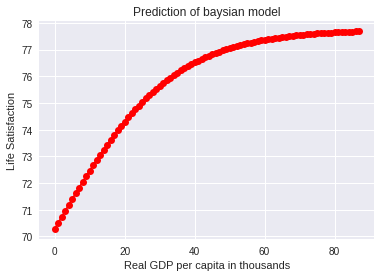

In [63]:
ina = np.arange(0,88,1)  # create the numbers on x-axis
out = np.tanh(ina*0.030)*7.490+70.280 #create outcome based on the numbers found by the baysian model


plt.plot(ina, out, color = 'red', marker = "o") # plot x and outcome
plt.title("Prediction of baysian model") # print title
plt.xlabel("Real GDP per capita in thousands") # set x-label
plt.ylabel("Life Satisfaction") # set y-label
plt.show() # show graph

# Sensitivity analysis (0.5 points)

If you do a theory notebook, program different values for the parameters, use different functional forms and solve your model again for these new values. Show that the outcomes are robust to such changes.

If you are using data, how sensitive are your results to outliers in the data, different choices when cleaning the data, different functional forms for the relations that you estimate.


# Discussion and conclusion (0.5 points)

What did you find in the analysis above; what is the answer to the question you started out with.

What are weaknesses of your approach that can be improved upon in future research (e.g. in your thesis).


# Sources 
